# Modelling

This is the second notebook of our project. Previously in the first notebook, we discussed our problem statement, followed by data cleaning and exploratory data analysis on the train dataset.

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score

from imblearn.over_sampling import SMOTE

# Functions

In [3]:
def append_results(result, train_score, metric, classifier):
    tmp = pd.DataFrame({
        'model':classifier,
        'train_accuracy': train_score,
        'test_accuracy': metric[metric['metric'] == 'accuracy']['score'].values[0],
        'misclassification': metric[metric['metric'] == 'misclassification_rate']['score'].values[0],
        'sensitivity': metric[metric['metric'] == 'sensitivity']['score'].values[0],
        'specificity': metric[metric['metric'] == 'specificity']['score'].values[0],
        'precision': metric[metric['metric'] == 'precision']['score'].values[0],
        'f1_score': metric[metric['metric'] == 'f1_score']['score'].values[0],
        'roc_auc':metric[metric['metric'] == 'roc_auc']['score'].values[0],
        #'misclassed_data':misclass_data
    }, index=[0])
    result = pd.concat([result,tmp], axis=0, ignore_index=True)
    return result

In [4]:
def metrics_and_plot_cm(classifier, X, y):
    preds = classifier.predict(X)
    tn, fp, fn, tp = confusion_matrix(y, preds).ravel()
    acc = (tp + tn) / (tn + fp + fn + tp)
    misclass = 1 - acc
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    prec = tp / (tp + fp)
    f_one_score = f1_score(y, preds)
    roc_auc = roc_auc_score(y, classifier.predict_proba(X)[:,1])
    results = {
        'accuracy': acc,
        'misclassification_rate': misclass,
        'sensitivity': sens,
        'specificity': spec,
        'precision': prec,
        'f1_score':f_one_score,
        'roc_auc':roc_auc
    }
    fig, axes = plt.subplots(ncols=2, figsize=(13,5))
    cm_chart = plot_confusion_matrix(classifier, X, y, cmap='Blues', values_format='d', ax=axes[0]);
    # cm_chart = plot_confusion_matrix(classifier, X, y, cmap='Blues', values_format='d',display_labels=['WNV Not Present (0)','WNV Present (1)'], ax=axes[0]);
    roc_curve = plot_roc_curve(classifier, X, y, ax=axes[1])
    axes[1].plot([0, 1], [0, 1], label='baseline', linestyle='--' )
    metrics = pd.DataFrame({
        'metric': results.keys(),
        'score': results.values()
        })
    return metrics

In [5]:
# def get_misclassed_data(test_data,predicted, actual):
#     df = pd.DataFrame({
#         'predicted':predicted,
#         'actual':actual
#     })
#     idx = df[df['predicted'] != df['actual']].index
#     tmp_lst = [i for i in test_data[idx]]
#     return [tmp_lst]


In [6]:
def output_results(preds, filename):
    preds_to_df = pd.DataFrame(preds, columns=['0','1'])
    preds_to_df.drop('0',axis=1, inplace=True)
    preds_to_df.rename(columns={'1':'Wnvpresent'}, inplace=True)
    preds_to_df.index.rename('id', inplace=True)
    preds_to_df.index += 1
    preds_to_df.to_csv(f'./assets/{filename}.csv', index=True)

# Reading Data and Preprocessing

In [7]:
train_comb = pd.read_csv('./assets/train_comb.csv')

In [8]:
train_comb['date'] = pd.to_datetime(train_comb['date'])
train_comb.set_index('date', inplace=True)

In [9]:
# dropping trap column for now as it is not numeralize yet
X = train_comb.drop(columns=['wnvpresent'])
y = train_comb['wnvpresent']

In [10]:
# train/test split on data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [11]:
# Scale X data
ss = StandardScaler()
Xs_train, Xs_val = ss.fit_transform(X_train), ss.transform(X_val)

## Baseline Score

In [12]:
train_comb['wnvpresent'].value_counts(normalize=True)

0    0.944966
1    0.055034
Name: wnvpresent, dtype: float64

The baseline accuracy score would be 0.945. We note from our target column: `wnvpresent` that there is massive class imbalance. We can resolve this by using SMOTE and include it in the pipeline for each of our models.

In [13]:
results_df = pd.DataFrame(columns=[
    'model',
    'train_accuracy',
    'test_accuracy',
    'misclassification',
    'sensitivity',
    'specificity',
    'precision',
    'f1_score',
    'roc_auc'
])

## Logistic Regression

In [14]:
# instantiate pipeline
pipe_logreg = Pipeline([('sampling', SMOTE(random_state=100)),
                ('logreg', LogisticRegression(solver='liblinear', random_state=100))
                ])

In [15]:
# set params to gridsearch
# pipe_logreg_params = {
#     'logreg__penalty': ['l1','l2'],
#     'logreg__C': [0.5, 1, 1.5, 2],
#     'sampling__sampling_strategy': ['not majority','auto'],
#     'sampling__k_neighbors': [3, 5],
# }


pipe_logreg_params = {
    'logreg__penalty': ['l1'],
    'logreg__C': [1.5],
    'sampling__sampling_strategy': ['not majority','auto'],
    'sampling__k_neighbors': [5],
}

In [16]:
gs_logreg = GridSearchCV(pipe_logreg, pipe_logreg_params, verbose=2, n_jobs=-1)

In [17]:
%%time
gs_logreg.fit(Xs_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Wall time: 16.1 s


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE(random_state=100)),
                                       ('logreg',
                                        LogisticRegression(random_state=100,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.5, 1, 1.5, 2],
                         'logreg__penalty': ['l1', 'l2'],
                         'sampling__k_neighbors': [3, 5],
                         'sampling__sampling_strategy': ['not majority',
                                                         'auto']},
             verbose=2)

In [18]:
gs_logreg.best_params_

{'logreg__C': 1.5,
 'logreg__penalty': 'l1',
 'sampling__k_neighbors': 5,
 'sampling__sampling_strategy': 'not majority'}

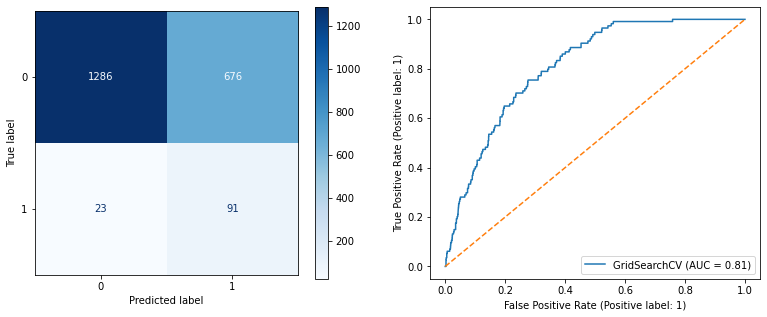

In [19]:
mod_metrics = metrics_and_plot_cm(gs_logreg, Xs_val, y_val)

In [20]:
results_df = append_results(results_df,
                           gs_logreg.score(Xs_train, y_train),
                           mod_metrics,
                           'Logistic Regression'
                           )

In [21]:
results_df

,model,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc
0,Logistic Regression,0.672768,0.663295,0.336705,0.798246,0.655454,0.118644,0.206583,0.811061


## SVM

In [22]:
# instantiate pipeline
pipe_svc = Pipeline([('sampling', SMOTE()),
                 ('svc', SVC(probability=True, random_state=100)) # probability=True is needed to calculate predict_proba but fitting grid model would take very long
                ])

In [23]:
# pipe_svc_params = {
#     'svc__C': [5, 7, 9],
#     'svc__kernel': ['rbf'],  #'poly'
#     'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
#     'sampling__k_neighbors': [3, 5],      
# }

pipe_svc_params = {
    'svc__C': [5],
    'svc__kernel': ['rbf'],  #'poly'
    'sampling__sampling_strategy': ['not minority', 'auto'],
    'sampling__k_neighbors': [3],      
}

In [24]:
gs_svc = GridSearchCV(pipe_svc, pipe_svc_params, verbose=2, n_jobs=-1)

In [25]:
%%time
gs_svc.fit(Xs_train, y_train)

# wall time is cut by half we dont put SVC(probability=True) in the pipeline

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Wall time: 1min 30s


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE()),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=100))]),
             n_jobs=-1,
             param_grid={'sampling__k_neighbors': [3, 5],
                         'sampling__sampling_strategy': ['minority',
                                                         'not minority',
                                                         'auto'],
                         'svc__C': [5, 7, 9], 'svc__kernel': ['rbf']},
             verbose=2)

In [26]:
gs_svc.best_params_

{'sampling__k_neighbors': 3,
 'sampling__sampling_strategy': 'not minority',
 'svc__C': 5,
 'svc__kernel': 'rbf'}

<ipython-input-4-3a9f30b834b7>:8: RuntimeWarning: invalid value encountered in longlong_scalars
  prec = tp / (tp + fp)


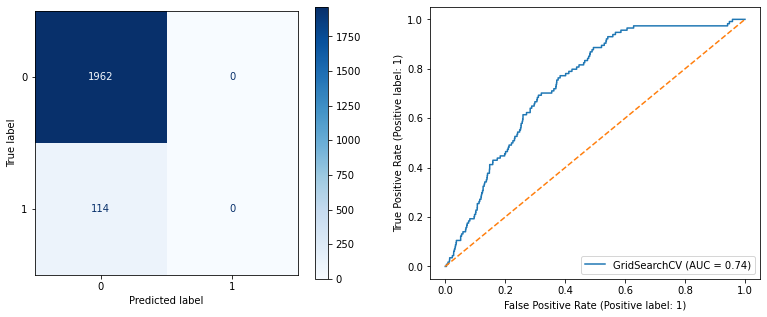

In [27]:
mod_metrics = metrics_and_plot_cm(gs_svc, Xs_val, y_val)

In [28]:
results_df = append_results(results_df,
                           gs_svc.score(Xs_train, y_train),
                           mod_metrics,
                           'SVM',
                           )

In [29]:
results_df

,model,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc
0,Logistic Regression,0.672768,0.663295,0.336705,0.798246,0.655454,0.118644,0.206583,0.811061
1,SVM,0.944926,0.945087,0.054913,0.000000,1.000000,NaN,0.000000,0.740993


## PCA

In [30]:
# instantiate pca
pca = PCA(random_state=100)

In [31]:
pca.fit(Xs_train)

PCA(random_state=100)

In [32]:
Z_train, Z_val = pca.transform(Xs_train), pca.transform(Xs_val)

In [33]:
pca.explained_variance_ratio_.round(3)

array([0.241, 0.121, 0.113, 0.077, 0.061, 0.051, 0.049, 0.046, 0.037,
       0.036, 0.034, 0.031, 0.023, 0.022, 0.019, 0.015, 0.008, 0.006,
       0.004, 0.003, 0.002, 0.   , 0.   ])

In [34]:
pca.explained_variance_ratio_.round(3)[:10].sum()

0.8320000000000001

We see that the first 10 components explain 77% of the variance.

In [35]:
pca.explained_variance_ratio_.round(3)[:25].sum()

0.999

The first 25 component explain 100% of the variance.

### Logistic Regression with PCA

In [36]:
# embed pca in a pipeline
pipe_pca_logreg = Pipeline([('sampling', SMOTE()),
                 ('pca', PCA()),
                 ('logreg', LogisticRegression(solver='liblinear', random_state=100))
                ])

In [37]:
# pipe_pca_logreg_params = {
#     'logreg__penalty': ['l1','l2'],
#     'logreg__C': [1, 1.5, 2],
#     'pca__n_components': [20, 30, 40],
#     'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
#     'sampling__k_neighbors': [3, 5],
# }

pipe_pca_logreg_params = {
    'logreg__penalty': ['l1'],
    'logreg__C': [1],
    'pca__n_components': [20],
    'sampling__sampling_strategy': ['not minority', 'auto'],
    'sampling__k_neighbors': [3],
}

In [38]:
gs_pca_logreg = GridSearchCV(pipe_pca_logreg, pipe_pca_logreg_params, verbose=2, n_jobs=-1)

In [39]:
%%time
gs_pca_logreg.fit(Xs_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Wall time: 5.82 s


C:\Users\Seraphim\anaconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.66184855 0.9450868  0.66473818 0.66570333 0.9450868  0.66602448
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.66377381 0.94492616 0.66473651 0.66779039 0.94492616 0.66714666
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.6676291  0.94492616 0.66634422 0.6689136  0.94492616 0.66843129
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.66538127 0.94476551 0.66618409 0.66907463 0.94476551 0.66634474
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.66634538 0.94492616 0.66891347 0.66875

GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE()), ('pca', PCA()),
                                       ('logreg',
                                        LogisticRegression(random_state=100,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logreg__C': [1, 1.5, 2],
                         'logreg__penalty': ['l1', 'l2'],
                         'pca__n_components': [20, 30, 40],
                         'sampling__k_neighbors': [3, 5],
                         'sampling__sampling_strategy': ['minority',
                                                         'not minority',
                                                         'auto']},
             verbose=2)

In [40]:
gs_pca_logreg.best_params_

{'logreg__C': 1,
 'logreg__penalty': 'l1',
 'pca__n_components': 20,
 'sampling__k_neighbors': 3,
 'sampling__sampling_strategy': 'not minority'}

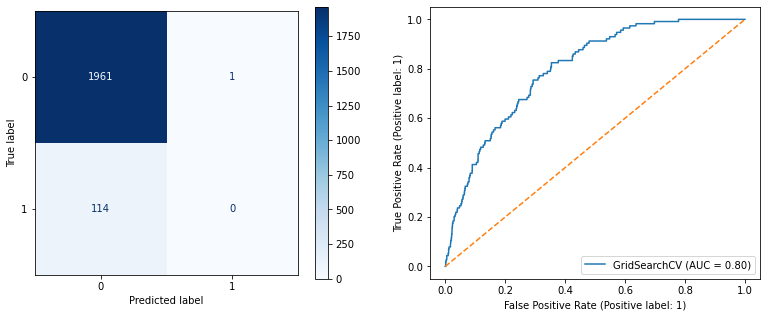

In [41]:
mod_metrics = metrics_and_plot_cm(gs_pca_logreg, Xs_val, y_val)

In [42]:
results_df = append_results(results_df,
                           gs_pca_logreg.score(Xs_train, y_train),
                           mod_metrics,
                           'PCA Logistic Regression',
                           )

In [43]:
results_df

,model,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc
0,Logistic Regression,0.672768,0.663295,0.336705,0.798246,0.655454,0.118644,0.206583,0.811061
1,SVM,0.944926,0.945087,0.054913,0.000000,1.000000,NaN,0.000000,0.740993
2,PCA Logistic Regression,0.944926,0.944605,0.055395,0.000000,0.999490,0.000000,0.000000,0.799746


### SVM with PCA

In [44]:
pipe_pca_svc = Pipeline([('sampling', SMOTE()),
                 ('pca', PCA()),
                 ('svc', SVC(probability=True, random_state=100))
])

In [45]:
# pipe_pca_svc_params = {
#     'svc__C': [5, 7, 9],
#     'svc__kernel': ['rbf'],  # 'poly'
#     'pca__n_components': [20, 30, 40],
#     'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
#     'sampling__k_neighbors': [3, 5],      
# }

pipe_pca_svc_params = {
    'svc__C': [5],
    'svc__kernel': ['rbf'],  # 'poly'
    'pca__n_components': [20],
    'sampling__sampling_strategy': ['not minority', 'auto'],
    'sampling__k_neighbors': [3],      
}

In [46]:
gs_pca_svc = GridSearchCV(pipe_pca_svc, pipe_pca_svc_params, verbose=2, n_jobs=-1)

In [47]:
%%time
gs_pca_svc.fit(Xs_train, y_train)

## lol example of time taken (14 mins) if we put SVC(probability=True) in the pipeline

Fitting 5 folds for each of 54 candidates, totalling 270 fits


C:\Users\Seraphim\anaconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.77729344 0.78468068 0.78580389 0.94492629 0.944605   0.944605
 0.78146925 0.77970244 0.78516261 0.78210976 0.78307374 0.78901648
 0.94492629 0.944605   0.944605   0.77938038 0.78837327 0.79174315
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan]
  warnings.warn(


Wall time: 1min 23s


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE()), ('pca', PCA()),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=100))]),
             n_jobs=-1,
             param_grid={'pca__n_components': [20, 30, 40],
                         'sampling__k_neighbors': [3, 5],
                         'sampling__sampling_strategy': ['minority',
                                                         'not minority',
                                                         'auto'],
                         'svc__C': [5, 7, 9], 'svc__kernel': ['rbf']},
             verbose=2)

In [48]:
gs_pca_svc.best_params_

{'pca__n_components': 20,
 'sampling__k_neighbors': 3,
 'sampling__sampling_strategy': 'not minority',
 'svc__C': 5,
 'svc__kernel': 'rbf'}

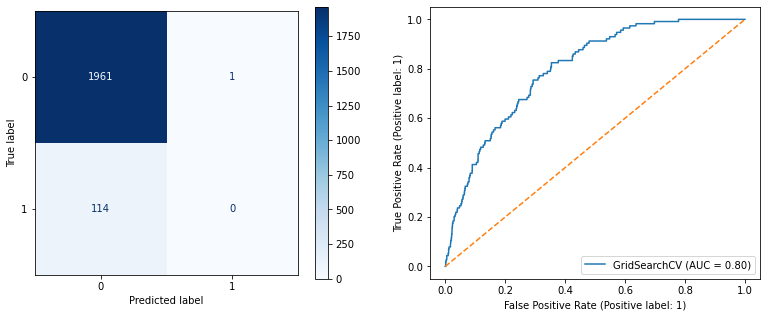

In [49]:
mod_metrics = metrics_and_plot_cm(gs_pca_logreg, Xs_val, y_val)

In [50]:
results_df = append_results(results_df,
                           gs_pca_svc.score(Xs_train, y_train),
                           mod_metrics,
                           'PCA SVM',
                           )

In [51]:
results_df

,model,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc
0,Logistic Regression,0.672768,0.663295,0.336705,0.798246,0.655454,0.118644,0.206583,0.811061
1,SVM,0.944926,0.945087,0.054913,0.000000,1.000000,NaN,0.000000,0.740993
2,PCA Logistic Regression,0.944926,0.944605,0.055395,0.000000,0.999490,0.000000,0.000000,0.799746
3,PCA SVM,0.944926,0.944605,0.055395,0.000000,0.999490,0.000000,0.000000,0.799746


## AdaBoost

To remove as it's not the best performing classifier.

In [52]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [53]:
pipe_ada = Pipeline([
    ('sampling', SMOTE()),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=100)))
])

In [54]:
pipe_ada_params = {
    'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
    'sampling__k_neighbors': [3, 5],  
    'ada__n_estimators': [50,100,150],
    'ada__learning_rate': [0.1,1,10]
}

In [55]:
gs_ada = GridSearchCV(pipe_ada, pipe_ada_params, verbose=1, n_jobs=-1)

In [56]:
gs_ada.fit(Xs_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE()),
                                       ('ada',
                                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=100)))]),
             n_jobs=-1,
             param_grid={'ada__learning_rate': [0.1, 1, 10],
                         'ada__n_estimators': [50, 100, 150],
                         'sampling__k_neighbors': [3, 5],
                         'sampling__sampling_strategy': ['minority',
                                                         'not minority',
                                                         'auto']},
             verbose=1)

In [57]:
gs_ada.best_params_

{'ada__learning_rate': 10,
 'ada__n_estimators': 50,
 'sampling__k_neighbors': 5,
 'sampling__sampling_strategy': 'not minority'}

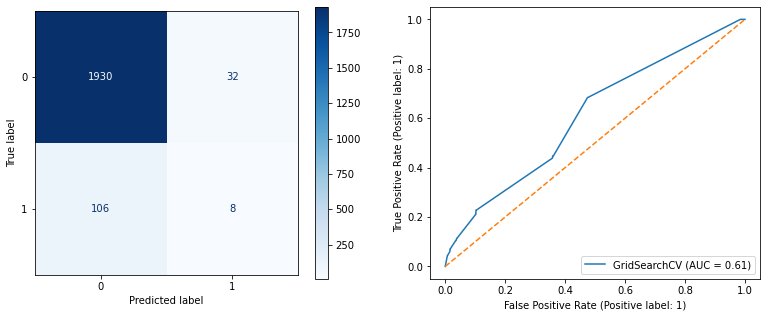

In [58]:
mod_metrics = metrics_and_plot_cm(gs_ada, Xs_val, y_val)

In [59]:
results_df = append_results(results_df,
                           gs_ada.score(Xs_train, y_train),
                           mod_metrics,
                           'AdaBoost',
                           )

In [60]:
results_df

,model,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc
0,Logistic Regression,0.672768,0.663295,0.336705,0.798246,0.655454,0.118644,0.206583,0.811061
1,SVM,0.944926,0.945087,0.054913,0.000000,1.000000,NaN,0.000000,0.740993
2,PCA Logistic Regression,0.944926,0.944605,0.055395,0.000000,0.999490,0.000000,0.000000,0.799746
3,PCA SVM,0.944926,0.944605,0.055395,0.000000,0.999490,0.000000,0.000000,0.799746
4,AdaBoost,0.956969,0.933526,0.066474,0.070175,0.983690,0.200000,0.103896,0.608225


# Predicting with Test Data

We utilise the whole train set as our train data here, and the test data to predict the probabilities, which will then be submitted to Kaggle for scoring.

In [61]:
X_train = pd.read_csv('./assets/X_train.csv')
y_train = pd.read_csv('./assets/y_train.csv')
X_test = pd.read_csv('./assets/test_final.csv')

In [62]:
# pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_columns', 50)

In [63]:
X_train.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
X_test.drop(columns=['Unnamed: 0','index'], inplace=True)
X_test.set_index('id', inplace=True)

In [64]:
gs_logreg.fit(X_train, y_train)
gs_svc.fit(X_train, y_train)
gs_pca_logreg.fit(X_train, y_train)
gs_pca_svc.fit(X_train, y_train)
gs_ada.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


C:\Users\Seraphim\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


C:\Users\Seraphim\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


C:\Users\Seraphim\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Fitting 5 folds for each of 54 candidates, totalling 270 fits


C:\Users\Seraphim\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Fitting 5 folds for each of 54 candidates, totalling 270 fits


C:\Users\Seraphim\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE()),
                                       ('ada',
                                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=100)))]),
             n_jobs=-1,
             param_grid={'ada__learning_rate': [0.1, 1, 10],
                         'ada__n_estimators': [50, 100, 150],
                         'sampling__k_neighbors': [3, 5],
                         'sampling__sampling_strategy': ['minority',
                                                         'not minority',
                                                         'auto']},
             verbose=1)

In [65]:
output_results(gs_logreg.predict_proba(X_test), 'logreg_results')
output_results(gs_svc.predict_proba(X_test), 'svc_results')
output_results(gs_pca_logreg.predict_proba(X_test), 'pca_logreg_results')
output_results(gs_pca_svc.predict_proba(X_test), 'pca_svc_results')
output_results(gs_ada.predict_proba(X_test), 'ada_results')

# Feature Importance

In [66]:
# note: svm on rbf has no feature importance, only svm on linear has it
# https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn

Feature Importance based on Logistic Regression

In [67]:
logreg_features = pd.DataFrame({'feature_names': X_train.columns,
                                'feature_importance': gs_logreg.best_estimator_[1].coef_[0]})

# top 20 features
logreg_features = logreg_features.sort_values(by='feature_importance', ascending=False).head(20)

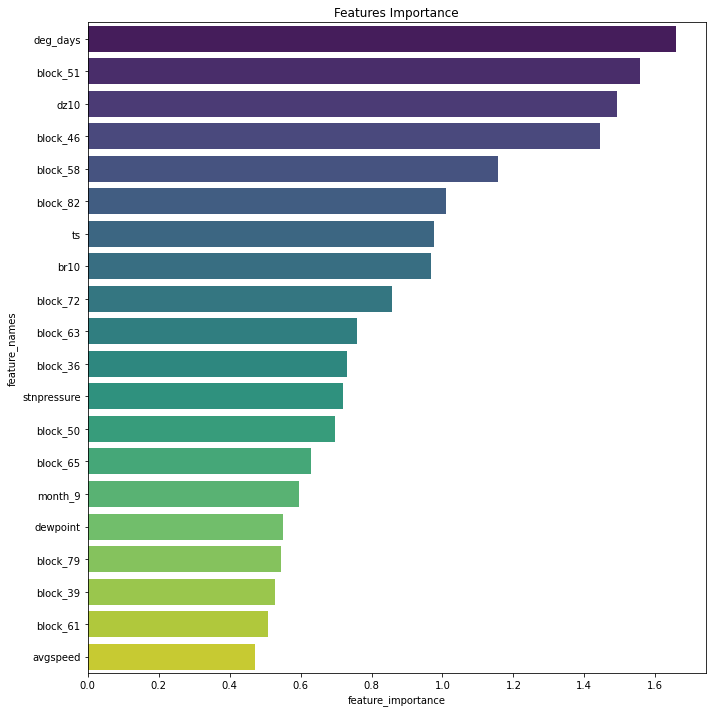

In [68]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(data=logreg_features, y='feature_names', x='feature_importance', palette='viridis')

plt.title('Features Importance')
plt.tight_layout()
plt.show()

# Cost Benefit Analysis

## Costs

Spraying Costs


- [Time of spray](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_communities/news/2020/august/city-to-spray-insecticide-thursday-to-kill-mosquitoes.html): Weather permitting, the spraying will begin at dusk on August 13th and continue through the night until approximately 1:00 am, with licensed mosquito abatement technicians in trucks dispensing an ultra-low-volume spray. The material being used to control the adult mosquitoes, Zenivex.


- [Spray rate of Zerivex](https://chicago.cbslocal.com/2017/08/30/spray-mosquitoes-far-south-side-west-nile-prevention/): The chemical used is Zenivex, applied at a rate of 1.5 fluid ounces per acre. That measure is approved by the U.S. EPA to control mosquitoes in outdoor residential and recreational areas.


- [Zerivex cost per acre](file:///C:/Users/caspe/Downloads/Zenivex%20Cost%20Comparison%20Fact%20Sheet.pdf): USD0.67 per acre



- Area of Chicago City: estimated to be 145,300 acres based on Google Search




Based on the above, we assume the cost of spray to be USD 0.67 per acre multiplied by the area of Chicago city. This accounts for 1 spraying exercise.

In [62]:
# cost of 1 spraying exercise
spray_cost = 145300*0.67
spray_cost

97351.0

The cost of 1 spraying exercise is about USD 97,351.

We assume we want to be aggresive and spray every week during the summer months of July, August and September based on our spray effectiveness analysis in the previous notebook.

In [63]:
# total cost of spraying annually
# assuming each spray * 4 weeks * 3 months
spray_cost * 4 * 3

1168212.0

For this scenario, we would need to set aside a budget of about USD 1.17 million to conduct the spraying exercises on an annual basis.

Medical Health Costs

  - Patients who were hospitalized with acute flaccid paralysis, a partial- to whole-body paralysis caused by WNV infection, had the largest initial and long-term medical costs ([median USD 25,000 and USD 22,000 respectively](https://www.sciencedaily.com/releases/2014/02/140210184713.htm)).
  
  
  - Number of [human WNV cases](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7241786/) in Chicago region (refer to Table 2 in the link): 24 in 2011 and 66 in 2013
  
  
  - The [CDC site](https://www.cdc.gov/westnile/index.html) shares that while there are no vaccines to prevent or medications to treat WNV in people, about 1 in 5 people who are infected develop a fever and other symptoms and about 1 out of 150 infected people develop a serious, sometimes fatal, illness.  
  


## Benefits

In a maximum benefit scenario, we assume that due to our aggressive spraying policy, no one contracted the virus.

Conversely, in a scenario where the spray had not been used: 

Based on CDC's estimates (1 in 150 people require hospitalization), we assume that 1 person aged 60 and above had contracted the virus and developed a serious illness requiring to be hospitalized. The approximate [economic productivity loss](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/) (referenced from Table 3 in the link) is calculated to be:


In [1]:
# Estimated economic costs of WNV cases due to productivity loss, proxy from a study in California
125*60

7500

The economic productivity loss of 1 person (aged 60 or above) hospitalized is estimated USD 7,500.

We conclude that the prevention of economic productivity loss of USD 7,500 does not justify the spending of USD 1.17 million to spray pesticides.

Based on the analysis above, there were <b>very little benefits</b> of the spraying in 2011 and 2013 due to the pathological nature of the WNV which we have studied so far. Furthermore, referencing back to our previous notebook on the spray data effectiveness analysis, the spray effectiveness is very sensitive to weather patterns.

# Conclusion

In effective pest management, one should consider the use of different spray types and effectiveness, as well as factors influencing the lifecycle of the pest.

When considering only fogging, the typical spray used in residential areas for combating mosquitos, timing of the spray should be strongly considered in reducing a mosquito population due to its time-constrained effectiveness:
1. Timing of rainfall
* Rainfall can have a large impact on the population of mosquitos, with stagnant, trapped water providing fertile breeding ground. In built-up cities such as Chicago, it can be difficult to get rid of all water traps and to completely eliminate sources of stagnant water. Use of fogging 8-10 days after a heavy downpour can be a timely way to eliminate mosquito populations for the day, as they are hatching, and accurately target the spray to its window of maximum effectiveness.

* Spray use should also be avoided when the timing coincides with predictions of rainfall on the day itself. For maximum effectiveness, sprays would have to remain in the air and interact with the mosquito population. Any precipitation during the course of the day would reduce the effectiveness of the spray by taking it out of the air and preventing maximum exposure.

2. Degree Days
* Mosquitos have shown to be most active around a specific temperature band, above 65F, often measured in degree days. When judging appropriate spray effectiveness, degree days can be used to help judge the use and timing of sprays. More days consistently above the 65F band would lead to a faster lifecycle, and a more active population, requiring a more consistent use of spraying. In contrast, we may avoid spraying on cooler days due to the limited effectivness of spraying, particularly when the mosquito population is small. Targeted use specifically in areas that have historically had the West Nile Virus presence can be considered instead.
* In examining our spray data set, sprays have largely been applied in September. This might be one big area of improvement for future spray applications, to shift them towards the summer months, when mosquitos are most active.

3. Wind Speed and Drift
* Wind speed should also be considered on the day of application. Wind speed can cause pesticide drift, removing the pesticide fog from its most effective location. Wind speed of the day should be considered during pesticide application. This is especially important in Chicago, which follows a grid layout, allowing buildings to form wind corridors and exacerbating wind effects. 
* Conversely, days with no wind speed can be difficult for spray operators, at speeds below 3km/h, spray can evaporate before arriving at the desired destination of application. A light breeze will provide the operator with the knowledge of the pesticide drift.

4. Sprayer Type
* Sprayer machinery can play an important role in the application of pesticides. A fine nozzle sprayer will help to provide a fine dispersion of the pesticide mist, however, hot days and lower humidity can lead to a faster evaporation of smaller droplets. Conversely, larger particle sizes (>200 microns) may survive the heat and be less affected by wind size, but may not be as effective at delivering the pesticide to pests.

5. Pesticide
* The assumption made is that the spray used is the most commonly use spray for fogging the air and targeting adult mosquitoes. However, standing pesticides can also be used in conjunction with air pesticides, targeting difficult to reach or difficult to clear areas with standing water to eliminate mosquito larvae. This would be a far more long-reaching solution, although constant re-application would be required through each rainfall. Therefore, consideration would have to be given according to the frequency of rainfall and the difficulty of application.

In conclusion, there were no material benefit to the spraying of pesticides conducted in 2011 and 2013. Therefore, the [best and most economical way](https://www.cdc.gov/westnile/prevention/index.html) to prevent West Nile disease or any other mosquito-borne illness is to reduce the number of mosquitoes around your home and to take personal precautions to avoid mosquito bites. Precautions include:

- When outdoors, apply insect repellent that contains DEET, picaridin, oil of lemon eucalyptus or IR 3535, according to label instructions.
- Wear long-sleeved shirts and long pants when going out
- Make sure doors and windows have tight-fitting screens. Repair or replace screens that have tears or other openings. Try to keep doors and windows shut, especially at night.
- Eliminate sources of water-holding containers that can support mosquito breeding such as tires, buckets, planters, toys, pools, birdbaths, flowerpots, or trash containers
- In communities where there are organized mosquito control programs, contact your municipal government to report areas of stagnant water in roadside ditches, flooded yards and similar locations that may produce mosquitoes.